In [1]:
#CREAR UN INDEX PARA ALMACENAR LOS DATOS
from elasticsearch import Elasticsearch
from pprint import pprint

es = Elasticsearch()

if not(es.indices.exists(index="tp5-championstweet")):
    res = es.indices.create(index="tp5-championstweet")  
    pprint(res)

In [2]:
#LISTAR LOS ARCHIVOS DEL DATASET
import json
import os
files = os.listdir("split_dataset_1")
pprint(len(files))

354585


from elasticsearch import helpers

#CARGAR LOS DATOS EN ELASTICSEARCH
tweets=[]

for filename in files:
    with open('split_dataset_1/'+filename) as f:
        try:
            #pprint(filename+':')
            tweet = json.load(f)
            timestamp=int(tweet["timestamp_ms"])
            #pprint(tweet)
            simple_tweet = {
                "timestamp":timestamp, \
                "date":tweet["created_at"], \
               "text": tweet['text'], \
               "username": tweet['user']['name'], \
               "location": tweet['user']['location']}
        except KeyError:
            error="error"
            
    tweets.append(simple_tweet)#remove comment
    
    #CARGAMOS LOS DATOS EN ELASTICSEARCH CON CONSULTAS 'BULK' PARA OPTIMIZAR EL PROCESO
    if (len(tweets)>=1000):
        i=0
        docs_as_string="["
        while i<1000:
            if i!=0:
                docs_as_string = docs_as_string + ','
            docs_as_string = docs_as_string + '\n' + json.dumps(tweets[i])
            i=i+1
        docs_as_string=docs_as_string+"]"
        res = helpers.bulk(es, json.loads(docs_as_string),index="tp5-championstweet", doc_type="_doc")
        tweets=[]

In [3]:
#CONSULTA BÁSICA A ELASTICSEARCH PARA PROBAR
res = es.search(index="tp5-championstweet", body={"query": {"match_all": {}}})
print("Got %d Hits:" % res['hits']['total'])
for hit in res['hits']['hits']:
    #print("TWEET:%(text)s %(username)s: %(date)s" % hit["_source"])
    print(hit)

Got 136000 Hits:
{'_index': 'tp5-championstweet', '_type': '_doc', '_id': 'WeUtgWQBEmehqEuVg7kE', '_score': 1.0, '_source': {'timestamp': 1527360864662, 'date': 'Sat May 26 18:54:24 +0000 2018', 'text': 'RT @SenegalFootball: HALA MANÉ Y NADA MAS!!!!\n\n#UCLfinal #RMALIV', 'username': '❄️ND❄️', 'location': 'Midland, TX'}}
{'_index': 'tp5-championstweet', '_type': '_doc', '_id': 'W-UtgWQBEmehqEuVg7kE', '_score': 1.0, '_source': {'timestamp': 1527367457819, 'date': 'Sat May 26 20:44:17 +0000 2018', 'text': 'Mir tut #Karius so dermaßen leid. \n\n#UCLfinal #RMALFC', 'username': 'Devious_99', 'location': 'Deutschland'}}
{'_index': 'tp5-championstweet', '_type': '_doc', '_id': 'X-UtgWQBEmehqEuVg7kE', '_score': 1.0, '_source': {'timestamp': 1527363693817, 'date': 'Sat May 26 19:41:33 +0000 2018', 'text': 'RT @ActualidadRT: #UCLfinal Real Madrid – Liverpool \nTermina una primera parte muy igualada en todos los sentidos. Carvajal y Salah se fuer…', 'username': 'tupamaro tachira', 'location': 'TA

In [4]:
res = es.search(index="tp5-championstweet", body={ "query" : { "term" : { "text" : "liverpool" }}})
print(res)

{'took': 394, 'timed_out': False, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}, 'hits': {'total': 16993, 'max_score': 4.0620193, 'hits': [{'_index': 'tp5-championstweet', '_type': '_doc', '_id': 'uOUvgWQBEmehqEuV8e7C', '_score': 4.0620193, '_source': {'timestamp': 1527360909914, 'date': 'Sat May 26 18:55:09 +0000 2018', 'text': 'Liverpool!  Liverpool!  Liverpool!  Liverpool!  Liverpool!  Liverpool!  Liverpool!  \n#TrustInKlopp\n#UCLfinal', 'username': 'Trümmertom', 'location': 'Europa, Europe ≠ EU'}}, {'_index': 'tp5-championstweet', '_type': '_doc', '_id': 'wOY1gWQBEmehqEuVMkB8', '_score': 4.0620193, '_source': {'timestamp': 1527360909914, 'date': 'Sat May 26 18:55:09 +0000 2018', 'text': 'Liverpool!  Liverpool!  Liverpool!  Liverpool!  Liverpool!  Liverpool!  Liverpool!  \n#TrustInKlopp\n#UCLfinal', 'username': 'Trümmertom', 'location': 'Europa, Europe ≠ EU'}}, {'_index': 'tp5-championstweet', '_type': '_doc', '_id': 'znXCiWQBnVtNqnmxRUZs', '_score': 4.0620193,

In [5]:
res = es.search(index="tp5-championstweet", body={ "query" : {"bool" : { "should" : {"match":{"text":"gol" }}}}})
pprint(res)

{'_shards': {'failed': 0, 'skipped': 0, 'successful': 5, 'total': 5},
 'hits': {'hits': [{'_id': 'NXXIiWQBnVtNqnmxs6ad',
                    '_index': 'tp5-championstweet',
                    '_score': 8.564864,
                    '_source': {'date': 'Sat May 26 20:29:55 +0000 2018',
                                'location': 'home is where the heart is ',
                                'text': 'RT @REAL_TOTAL: GOL GOL GOL GOL GOL '
                                        'GOL GOL GOL GOL GOL GOL GOL GOL GOL '
                                        'GOL GOL GOL GOL GOL! @GarethBale11 '
                                        'schon wieder! GARETH. BALE!!!!!!…',
                                'timestamp': 1527366595824,
                                'username': 'just a nerdy Guy'},
                    '_type': '_doc'},
                   {'_id': 'J-Y5gWQBEmehqEuVeaD-',
                    '_index': 'tp5-championstweet',
                    '_score': 8.548047,
                   

In [6]:
#CONSULTA: ¿Cuántos tweets cada minuto?
res = es.search(index="tp5-championstweet", body={"aggs" : { "tweets_over_time" : \
                                                            { "date_histogram" : { "field" : \
                                                                                  "timestamp", "interval" : "1m" \
                                                                                 }}}})
for data in res['aggregations']['tweets_over_time']['buckets']:
    print(data['doc_count'])

15
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
8
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
83
1183
1166
1121
1026
1000
870
897
1018
1078
985
908
818
780
793
878
942
870
860
816
894
873
877
922
1158
1025
966
1104
1163
1027
1252
1283
1202
1189
1161
1215
1185
1097
1173
1165
1187
1102
1184
1213
1148
1145
1152
1196
1090
1193
1119
1134
1319
1161
1148
1258
1224
1233
1260
1152
1092
1164
1177
1199
1170
1229
1219
1129
1173
1216
1210
1210
1193

In [7]:
res

{'took': 262,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0},
 'hits': {'total': 136000,
  'max_score': 1.0,
  'hits': [{'_index': 'tp5-championstweet',
    '_type': '_doc',
    '_id': 'WeUtgWQBEmehqEuVg7kE',
    '_score': 1.0,
    '_source': {'timestamp': 1527360864662,
     'date': 'Sat May 26 18:54:24 +0000 2018',
     'text': 'RT @SenegalFootball: HALA MANÉ Y NADA MAS!!!!\n\n#UCLfinal #RMALIV',
     'username': '❄️ND❄️',
     'location': 'Midland, TX'}},
   {'_index': 'tp5-championstweet',
    '_type': '_doc',
    '_id': 'W-UtgWQBEmehqEuVg7kE',
    '_score': 1.0,
    '_source': {'timestamp': 1527367457819,
     'date': 'Sat May 26 20:44:17 +0000 2018',
     'text': 'Mir tut #Karius so dermaßen leid. \n\n#UCLfinal #RMALFC',
     'username': 'Devious_99',
     'location': 'Deutschland'}},
   {'_index': 'tp5-championstweet',
    '_type': '_doc',
    '_id': 'X-UtgWQBEmehqEuVg7kE',
    '_score': 1.0,
    '_source': {'timestamp': 1527363693817,


In [8]:
import pandas as pd

df_tweetsByMinutes = pd.DataFrame(res['aggregations']['tweets_over_time']['buckets'])
df_tweetsByMinutes = df_tweetsByMinutes.rename(columns={'key': 'timestamp', 'doc_count': 'nb_tweets'})
df_tweetsByMinutes[:10]

,nb_tweets,timestamp
0,15,1527340680000
1,0,1527340740000
2,0,1527340800000
3,0,1527340860000
4,0,1527340920000
5,0,1527340980000
6,0,1527341040000
7,0,1527341100000
8,0,1527341160000
9,0,1527341220000


In [9]:
df_tweetsByMinutes_filtered = df_tweetsByMinutes.drop(df_tweetsByMinutes[df_tweetsByMinutes.timestamp < 1527357600000 ].index)
df_tweetsByMinutes_filtered[:10]

,nb_tweets,timestamp
282,0,1527357600000
283,0,1527357660000
284,0,1527357720000
285,0,1527357780000
286,0,1527357840000
287,0,1527357900000
288,0,1527357960000
289,0,1527358020000
290,0,1527358080000
291,0,1527358140000


In [10]:
import datetime

def timestamp2date(x):
    y = datetime.datetime.fromtimestamp(x/1000).strftime('%H:%M:%S')
    return y

df_tweetsByMinutes_filtered['timestamp']=df_tweetsByMinutes_filtered['timestamp'].apply(timestamp2date)
df_tweetsByMinutes_filtered[:10]

,nb_tweets,timestamp
282,0,14:00:00
283,0,14:01:00
284,0,14:02:00
285,0,14:03:00
286,0,14:04:00
287,0,14:05:00
288,0,14:06:00
289,0,14:07:00
290,0,14:08:00
291,0,14:09:00


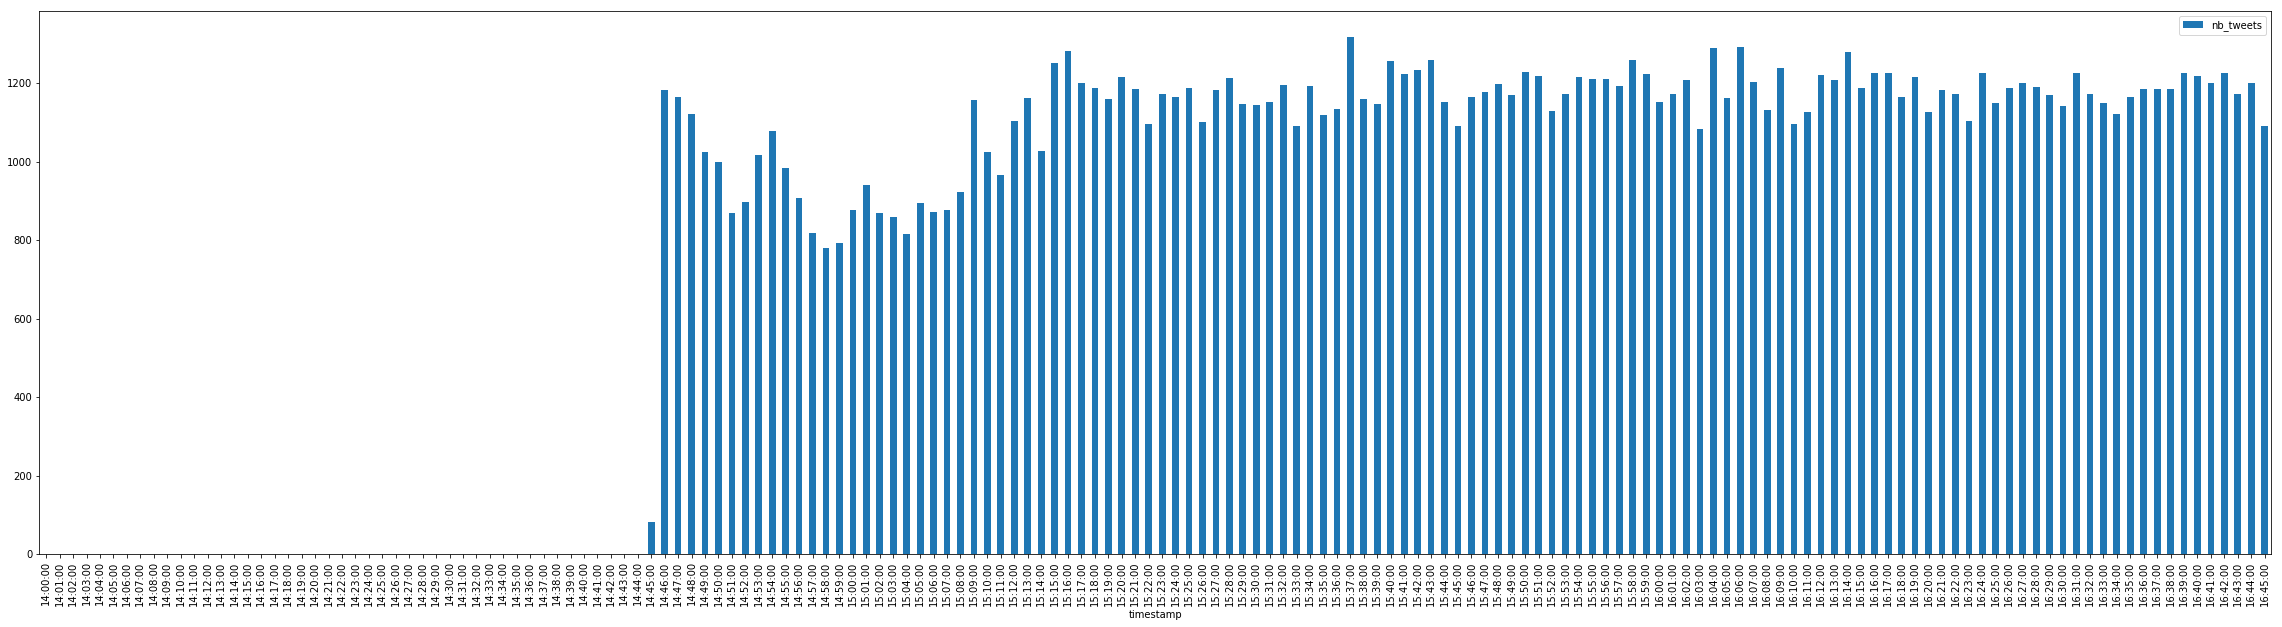

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

df_tweetsByMinutes_filtered.plot(kind='bar',figsize=(40,10), fontsize=10, x='timestamp')
plt.show()

In [12]:
#CONSULTA BÁSICA A ELASTICSEARCH PARA PROBAR
res = es.search(index="tp5-championstweet", body={"query": {"term":{"text":"goal"}}})
print("Got %d Hits:" % res['hits']['total'])
for hit in res['hits']['hits']:
    print("TWEET:%(text)s %(username)s: %(date)s" % hit["_source"])

Got 6500 Hits:
TWEET:Goal! Goal! Goal! Typical Liverpool goalkeepers #UCLfinal #HalaMadrid Tlholo conquer: Sat May 26 19:56:24 +0000 2018
TWEET:Goal! Goal! Goal! Typical Liverpool goalkeepers #UCLfinal #HalaMadrid Tlholo conquer: Sat May 26 19:56:24 +0000 2018
TWEET:Goal! Goal! Goal! Typical Liverpool goalkeepers #UCLfinal #HalaMadrid Tlholo conquer: Sat May 26 19:56:24 +0000 2018
TWEET:Goal na Goal Bros https://t.co/MKK2cL6pdL Melanin Boy: Sat May 26 20:05:20 +0000 2018
TWEET:Goal na Goal Bros https://t.co/MKK2cL6pdL Melanin Boy: Sat May 26 20:05:20 +0000 2018
TWEET:WHAT A GOAL BALE! WHAT A GOAL! 🔥🔥🔥🔥 💯  #UCLfinal Alma Aleel: Sat May 26 20:11:18 +0000 2018
TWEET:WHAT A GOAL BALE! WHAT A GOAL! 🔥🔥🔥🔥 💯  #UCLfinal Alma Aleel: Sat May 26 20:11:18 +0000 2018
TWEET:Goal #uclfinal SMITH: Sat May 26 19:56:20 +0000 2018
TWEET:Goal 🥅🤭 #UCLFinal Slyzzle: Sat May 26 20:00:18 +0000 2018
TWEET:Goal!!!!

#UCLfinal Bergville Art Festival #BAF: Sat May 26 19:55:49 +0000 2018


*****************************Preguntas*****************************************

1) ¿Cuántos tweets tienen la palabra "liverpool"? ¿Cómo se distribuye los tweets en el tiempo (ver en un histograma)

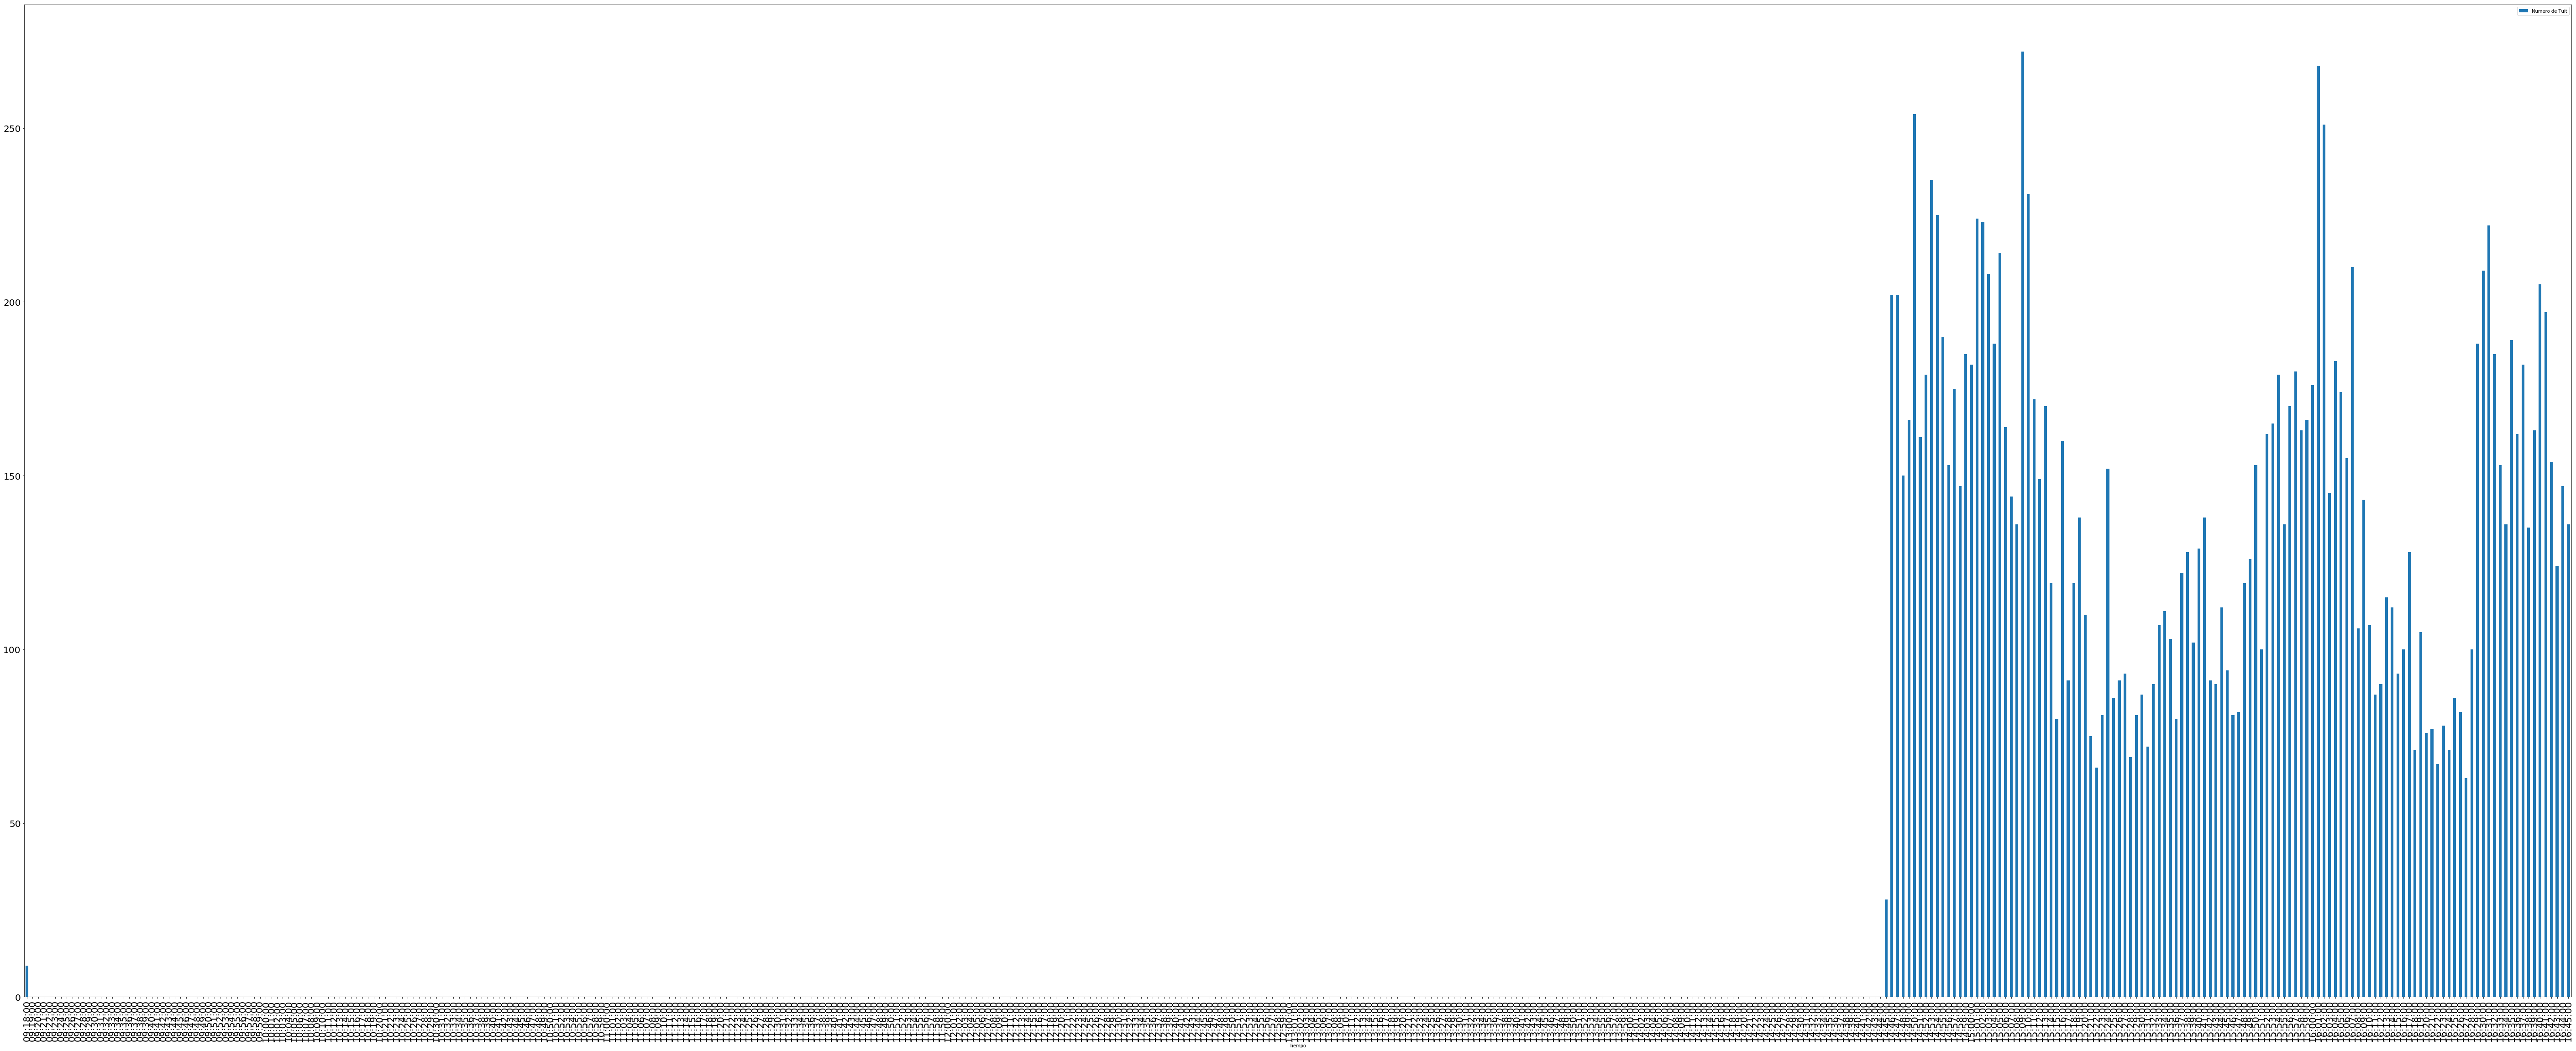

In [13]:
preg1= es.search(index="tp5-championstweet", body={"aggs" : { "tweets_over_time" : \
                                                            { "date_histogram" : { "field" : \
                                                                                  "timestamp", "interval" : "1m" \
                                                                                  }}},"query": {"match": {'text':'liverpool'}}})
datapreg1 = pd.DataFrame(preg1['aggregations']['tweets_over_time']['buckets'])
datapreg1=datapreg1.rename(columns={'key': 'Tiempo', 'doc_count': 'Numero de Tuit'})
datapreg1['Tiempo']=datapreg1['Tiempo'].apply(timestamp2date)
datapreg1.plot(kind='bar',figsize=(100,40), fontsize=20,x='Tiempo')

2) ¿De dónde vienen los tweets? (utilizar el campo 'location')


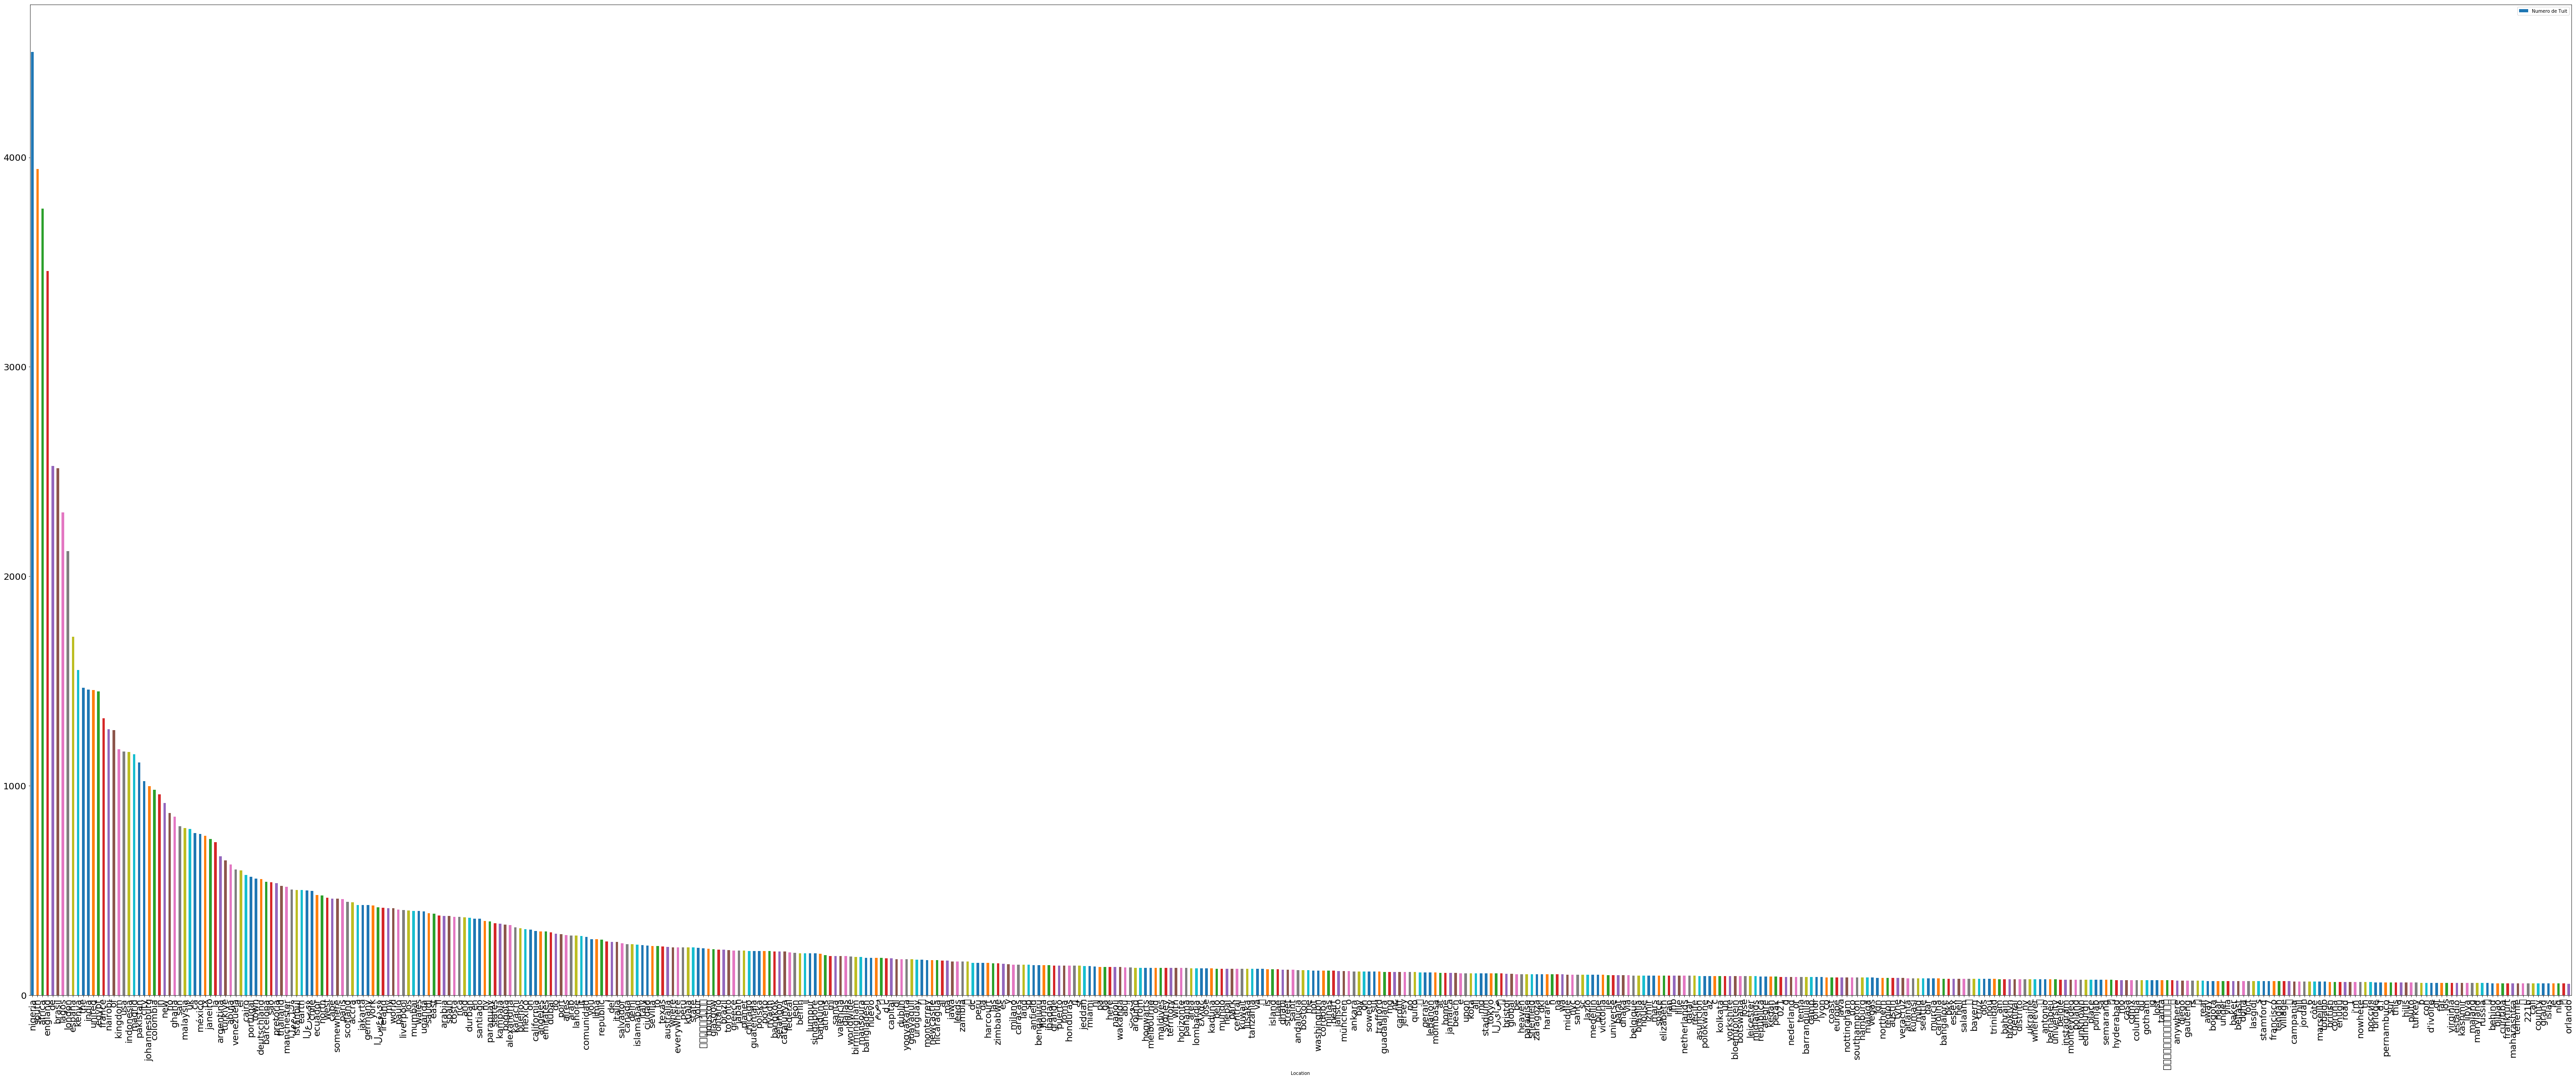

In [14]:
preg2 = es.search(index="tp5-championstweet", body={
"size": 50,
"aggs" : {
    "_source" : {
        "terms" : { 
            "field" : "location",  "size" : 500 }
    }
}})
datapreg2=pd.DataFrame(preg2['aggregations']['_source']['buckets'])
datapreg2=datapreg2.rename(columns={'key': 'Location', 'doc_count': 'Numero de Tuit'})
datapreg2.plot(kind="bar",figsize=(100,40), fontsize=20,x="Location", y='Numero de Tuit')

3) ¿Cuántos tweets tienen las palabras "liverpool" y "goal"? (ver en un histograma)


In [15]:
preg31 = es.search(index="tp5-championstweet", body={"query":{"match":{"text":"liverpool" }},"aggs" : { "tweets_over_time" : \
                                                            { "date_histogram" : { "field" : \
                                                                                  "timestamp", "interval" : "1m" \
                                                                                 }}}})
preg32 = es.search(index="tp5-championstweet", body={"query":{"match":{"text":"goal" }},"aggs" : { "tweets_over_time" : \
                                                            { "date_histogram" : { "field" : \
                                                                                  "timestamp", "interval" : "1m" \
                                                                                 }}}})

In [16]:
datapreg31=pd.DataFrame(preg31['aggregations']['tweets_over_time']['buckets'])
datapreg32=pd.DataFrame(preg32['aggregations']['tweets_over_time']['buckets'])


In [17]:
datapreg31=datapreg31.rename(columns={'key': 'timestamp', 'doc_count': 'NumDeLiverpool'})
datapreg32=datapreg32.rename(columns={'key': 'timestamp', 'doc_count': 'NumDeGoal'})
datapreg31['timestamp']=datapreg31['timestamp'].apply(timestamp2date)
datapreg32['timestamp']=datapreg32['timestamp'].apply(timestamp2date)

In [18]:
datafinal=pd.merge(datapreg31,datapreg32,on='timestamp')

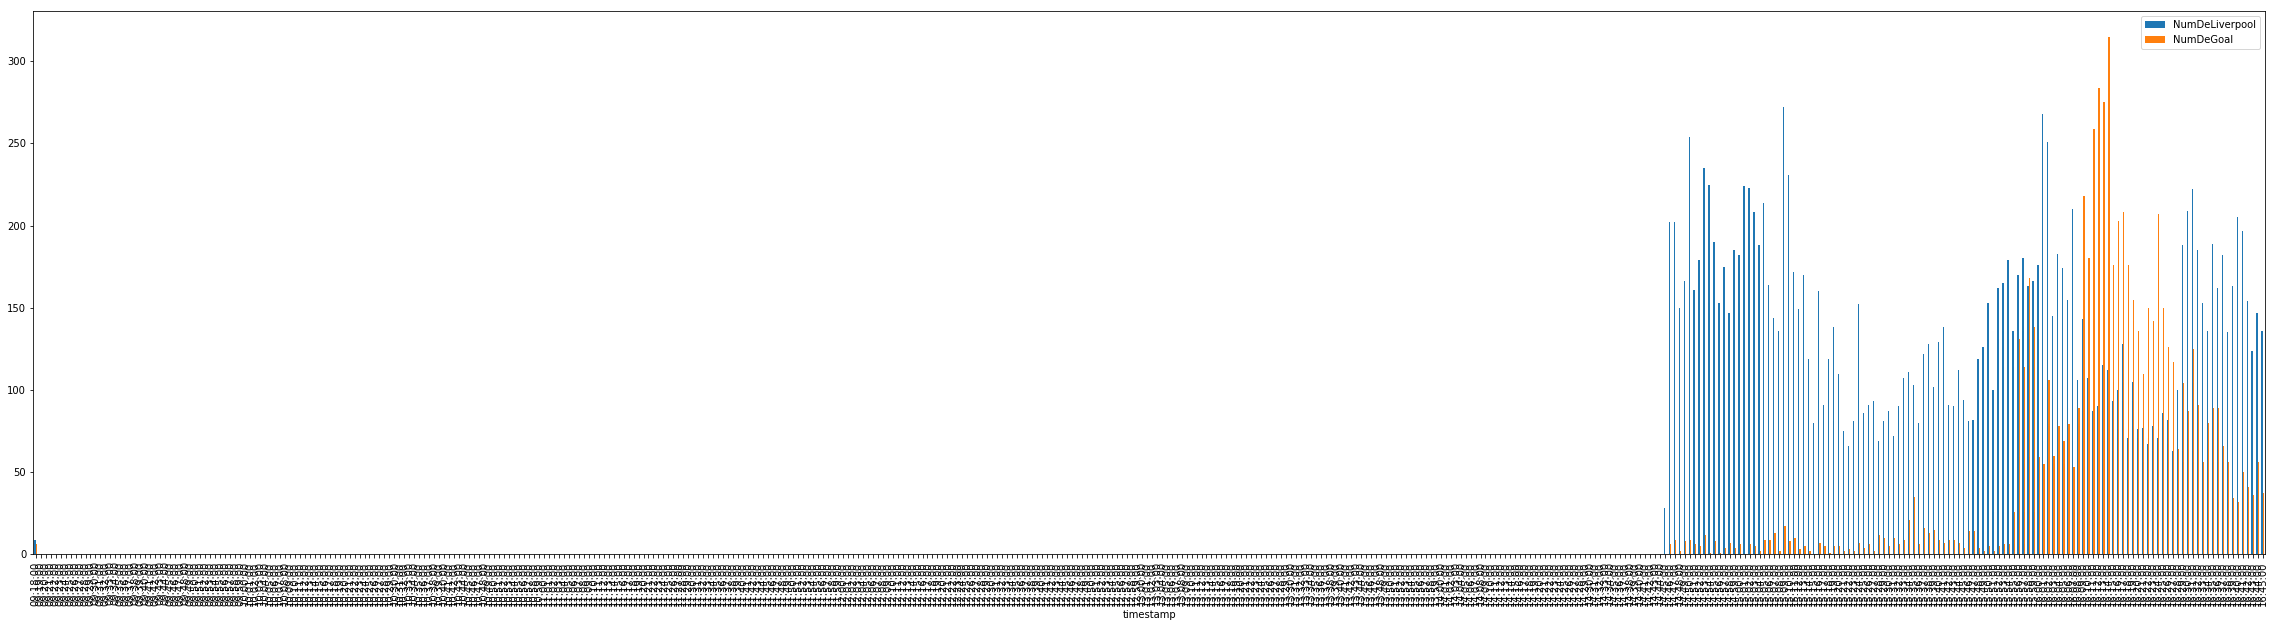

In [19]:
datafinal.plot(kind='bar',figsize=(40,10), fontsize=10, x='timestamp', y=['NumDeLiverpool','NumDeGoal'])
plt.show()

4) Graficar un Pie Chart comparando el número de tweets con: a) la palabra 'liverpool', b) la palabra 'madrid', c) la palabra 'madrid' y 'liverpool' d) ninguna de las palabras


In [20]:


preg41 = es.search(index="tp5-championstweet", body={"query":{"match":{"text":"madrid" }},"aggs" : { "tweets_over_time" : \
                                                            { "date_histogram" : { "field" : \
                                                                                  "timestamp", "interval" : "1m" \
                                                                                 }}}})
preg42 = es.search(index="tp5-championstweet", body={"query":{"match":{"text":"(madrid)+( )* (liverpool)+" }},"aggs" : { "tweets_over_time" : \
                                                            { "date_histogram" : { "field" : \
                                                                                  "timestamp", "interval" : "1m" \
                                                                                 }}}})


In [21]:
datamadrid=pd.DataFrame(preg41['aggregations']['tweets_over_time']['buckets'])
datamadliv=pd.DataFrame(preg42['aggregations']['tweets_over_time']['buckets'])

In [22]:
datamadrid=datamadrid.rename(columns={'key': 'timestamp', 'doc_count': 'Num tuit madrid'})
datamadliv=datamadliv.rename(columns={'key': 'timestamp', 'doc_count': 'Num tuit madrid + liverpool'})


In [23]:
datamadrid['timestamp']=datamadrid['timestamp'].apply(timestamp2date)
datamadliv['timestamp']=datamadliv['timestamp'].apply(timestamp2date)

In [24]:
datos1=pd.merge(datamadrid,datamadliv,on='timestamp')
datos2=pd.merge(datos1,datapreg31,on='timestamp')

In [25]:
datos2


,Num tuit madrid,timestamp,Num tuit madrid + liverpool,NumDeLiverpool
0,9,09:18:00,9,9
1,0,09:19:00,0,0
2,0,09:20:00,0,0
3,0,09:21:00,0,0
4,0,09:22:00,0,0
5,0,09:23:00,0,0
6,0,09:24:00,0,0
7,0,09:25:00,0,0
8,0,09:26:00,0,0
9,0,09:27:00,0,0


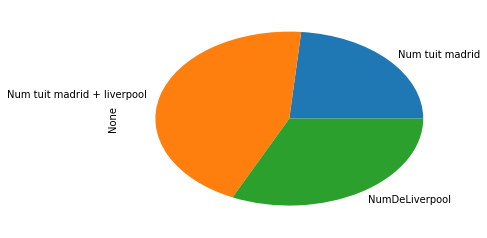

In [26]:
datos2[['Num tuit madrid','Num tuit madrid + liverpool','NumDeLiverpool']].sum().plot(kind='pie')

5) ¿Cuáles son los emoticons más frecuentes? A partir de las visualizaciones disponibles en las librerias MatplotLib y/o Seaborn (seaborn.pydata.org), proponer una visualización para observar las emociones expresadas durante el partido 

In [47]:
enojo = es.search(index="tp5-championstweet",body={"query":{"match":{"text":">:c" }},"aggs" : { "tweets_over_time" : \
                                                            { "date_histogram" : { "field" : \
                                                                                  "timestamp", "interval" : "1m" \
                                                                                 }}}})
euforia = es.search(index="tp5-championstweet",body={"query":{"match":{"text":"ehhh" }},"aggs" : { "tweets_over_time" : \
                                                            { "date_histogram" : { "field" : \
                                                                                  "timestamp", "interval" : "1m" \
                                                                                 }}}})
triste=es.search(index="tp5-championstweet",body={"query":{"match":{"text":":c" }},"aggs" : { "tweets_over_time" : \
                                                            { "date_histogram" : { "field" : \
                                                                                  "timestamp", "interval" : "1m" \
                                                                                 }}}})
feliz=es.search(index="tp5-championstweet",body={"query":{"match":{"text":":D" }},"aggs" : { "tweets_over_time" : \
                                                            { "date_histogram" : { "field" : \
                                                                                  "timestamp", "interval" : "1m" \
                                                                                 }}}})


In [48]:
eno=pd.DataFrame(enojo['aggregations']['tweets_over_time']['buckets'])
euf=pd.DataFrame(euforia['aggregations']['tweets_over_time']['buckets'])
tri=pd.DataFrame(triste['aggregations']['tweets_over_time']['buckets'])
fel=pd.DataFrame(feliz['aggregations']['tweets_over_time']['buckets'])
eno=eno.rename(columns={'key': 'timestamp', 'doc_count': 'Num enojados'})
euf=euf.rename(columns={'key': 'timestamp', 'doc_count': 'Num euforia'})
tri=tri.rename(columns={'key': 'timestamp', 'doc_count': 'Num tristes'})
fel=fel.rename(columns={'key': 'timestamp', 'doc_count': 'Num felices'})

eno['timestamp']=eno['timestamp'].apply(timestamp2date)
euf['timestamp']=euf['timestamp'].apply(timestamp2date)

tri['timestamp']=tri['timestamp'].apply(timestamp2date)
fel['timestamp']=fel['timestamp'].apply(timestamp2date)

In [50]:
primer=pd.merge(euf,eno,on='timestamp')
segundo=pd.merge(primer,tri,on='timestamp')
tercero=pd.merge(segundo,fel,on='timestamp')

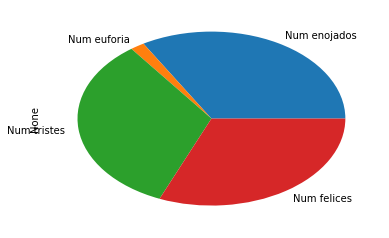

In [51]:
tercero[['Num enojados','Num euforia','Num tristes','Num felices']].sum().plot(kind='pie')

In [52]:
tercero[['Num enojados','Num euforia','Num tristes','Num felices']].sum()

Num enojados    78
Num euforia      4
Num tristes     78
Num felices     73
dtype: int64